# Differential expression analysis

Today we are going to learn how to perform differential expression analysis on aging bulk RNA-seq datasets. For this lesson we prepared longitudal RNA-seq data on aged human fibroblasts from Fleischer et al (2018). This data is already proccesed, therefore we can skip a large part devoted to raw read processing and mapping (Figure 1) and start with a table of counts.  

```{figure} figs/TitleFigure.png 
A typical workflow for DE analysis.
```

## Preparing the data 

We will start with uploading expression data table together with meta file containing brief sample description (age, ethnicity). While original study include both male and females profiles, we selected only the male ones for the simplicity of the further analysis. Processed files (*data_fibroblasts.csv* and *meta_fibroblasts.csv*) are available here: http://arcuda.skoltech.ru/~d.smirnov/ComputationalAgingCourse/

In [1]:
import numpy as np
import pandas as pd
import sys
from collections import Counter

path_data = "data/data_fibroblasts.csv" # change this with your actual path to data file
raw_counts = pd.read_csv(path_data, index_col=0)

Check the number of gene features and number of samples available in the dataset:

In [2]:
print("Number of genes:", raw_counts.shape[0])
print("Number of samples:", raw_counts.shape[1])

Number of genes: 29744
Number of samples: 99


This table includes expression profiles of 99 samples with 29744 genes detected. However, some of this genes can have zero expression values across samples. We will filter them out:

In [3]:
raw_counts = raw_counts.loc[~(raw_counts==0).all(axis=1)]
raw_counts.shape

(24033, 99)

Then we will load meta file with sample descriptions:

In [4]:
path_meta = "data/meta_fibroblasts.csv" # change this with your actual path to meta file
meta = pd.read_csv(path_meta, index_col=0)
meta.head(10)

,Age,Ethnicity
SRX4022456,1,Asian
SRX4022457,12,Caucasian
SRX4022459,25,Caucasian
SRX4022461,26,Caucasian
SRX4022463,28,Caucasian
SRX4022464,29,Caucasian
SRX4022465,29,Caucasian
SRX4022466,30,Caucasian
SRX4022468,30,Caucasian
SRX4022469,30,Caucasian


Let's check age range of our samples using the information from the first column of the *meta* 

In [5]:
print("Minimal age:", min(meta.Age.values))
print("Maximal age:", max(meta.Age.values))

Minimal age: 1
Maximal age: 96


To perform further analysis we will divide samples into age groups with a step = 10 years.

In [6]:
df = pd.DataFrame(pd.cut(meta["Age"], np.arange(0, max(meta.Age.values)+10, 10), right = False, ordered = True))
df.columns = ['AgeBins']
df['AgeBins'] = df['AgeBins'].astype(str)
meta = pd.concat([meta, df], axis=1)
meta = meta.replace(np.unique(meta['AgeBins'].values), np.arange(10))
meta['AgeRanges'] = df['AgeBins'].values.astype(str)
meta.head()

,Age,Ethnicity,AgeBins,AgeRanges
SRX4022456,1,Asian,0,"[0, 10)"
SRX4022457,12,Caucasian,1,"[10, 20)"
SRX4022459,25,Caucasian,2,"[20, 30)"
SRX4022461,26,Caucasian,2,"[20, 30)"
SRX4022463,28,Caucasian,2,"[20, 30)"


## Setting up rpy2 functions

In [7]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects.numpy2ri
pandas2ri.activate()
robjects.numpy2ri.activate()
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

In [8]:
deseq = importr('DESeq2')
sumexp = importr('SummarizedExperiment')
degreport = importr('DEGreport')
to_dataframe = robjects.r("function(x) data.frame(x)")
get_clusters = robjects.r("function(x) x[['df']]")
get_cluster_data = robjects.r("function(x) x[['normalized']]")
to_factors = robjects.r("function(x) data.frame(lapply(x,factor))")

In [9]:
class DESeq2():
    def __init__(self, counts, meta, design):
        self.raw_counts = robjects.conversion.py2rpy(counts.round().astype(int))
        self.meta_chr = robjects.conversion.py2rpy(meta)
        self.meta = to_factors(robjects.conversion.py2rpy(meta))
        self.design = design
        
    def create_deseq_object(self):
        self.dds = deseq.DESeqDataSetFromMatrix(countData=self.raw_counts, colData=self.meta, design=self.design)
        
    def normalization(self):
        self.dds = deseq.estimateSizeFactors_DESeqDataSet(self.dds)
        norm_counts = to_dataframe(deseq.counts_DESeqDataSet(self.dds, normalized=True))
        norm_counts = robjects.conversion.rpy2py(norm_counts)
        norm_counts.index = robjects.conversion.rpy2py(self.raw_counts).index
        norm_counts.columns = robjects.conversion.rpy2py(self.raw_counts).columns
        return norm_counts
    
    def transformation(self, method = "vst"):
        if method == "vst":
            mat = deseq.varianceStabilizingTransformation(self.dds, blind = True)
        elif method == "rlog":
            mat = deseq.rlog(self.dds, blind = True)
            
        mat = to_dataframe(sumexp.assay(mat))
        mat = robjects.conversion.rpy2py(mat)
        mat.index = robjects.conversion.rpy2py(self.raw_counts).index
        mat.columns = robjects.conversion.rpy2py(self.raw_counts).columns   
        return mat
    
    def LRT_testing(self):
        try:
            dds_lrt = deseq.DESeq(self.dds, test="LRT", reduced = Formula("~1"))
            res_LRT = to_dataframe(deseq.results(dds_lrt))
            res_LRT = robjects.conversion.rpy2py(res_LRT)
        except rpy2.rinterface_lib.embedded.RRuntimeError:
            sys.exit()
        return res_LRT
    
    def clustering(self, cluster_mat):
        cluster_mat = robjects.conversion.py2rpy(cluster_mat)
        dp = degreport.degPatterns(cluster_mat, metadata = self.meta_chr, time = "AgeBins")
        cluster_content = robjects.conversion.rpy2py(get_clusters(dp))
        cluster_data = robjects.conversion.rpy2py(get_cluster_data(dp))
        return cluster_content, cluster_data

## Normalization

Specify a design formula for statistical testing with DESeq2 (it is important to put the factor of interest in the end of the formula!):

In [10]:
design = Formula("~AgeBins")
d = DESeq2(raw_counts, meta, design)

Initialize DESeq2 object with our data:

In [11]:
d.create_deseq_object()

Perform DESeq2 normalization:

In [12]:
ncounts = d.normalization()

Then transform data using variance stabilizing transformation (VST) to get rid of heteroskedasticity:

In [13]:
vst_mat = d.transformation(method = "vst")

## Quality control

Before differential analysis we will explore a similarityof the samples in the age groups

### Principal Component Analysis

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [15]:
x = np.transpose(vst_mat.values)
x = StandardScaler().fit_transform(x)

In [16]:
pca = PCA(n_components=2)

In [17]:
principalComponents = pca.fit_transform(x)

In [18]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [19]:
pcdf = pd.concat([principalDf.set_index(meta.index), meta], axis = 1)

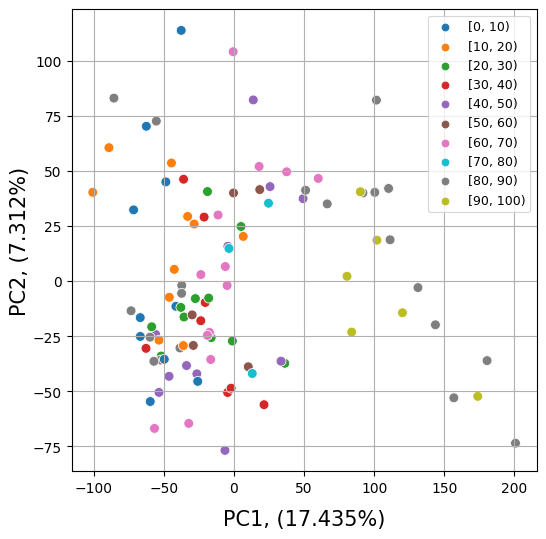

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_context("paper", font_scale=1.5)
sns.scatterplot(data=pcdf, x="PC1", y="PC2", hue="AgeRanges", s = 50)
plt.legend(loc="upper right", fontsize=5)

var_pc1 = (pca.explained_variance_ratio_[0]*100).round(3)
var_pc2 = (pca.explained_variance_ratio_[1]*100).round(3)
plt.xlabel('PC1, ('+ var_pc1.astype(str) + "%)", fontsize = 15, labelpad = 10)
plt.ylabel('PC2, ('+ var_pc2.astype(str) + "%)", fontsize = 15, labelpad = 2)

handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5,6,9,7,8]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=9)

ax.grid()

```{admonition} Exercise 1
:class: dropdown
Perform PCA on the top 500 most variable genes in the dataset (1 point).
```

In [21]:
variance = vst_mat.var(axis = 1, numeric_only = True)

In [22]:
N = 500
top_cols = variance.sort_values(ascending = False).index[:N]
vst_mat_transpose = vst_mat.T
vst_mat_high_variance = vst_mat_transpose[top_cols]
vst_mat_top_genes = vst_mat_high_variance.T

In [23]:
top_cols

Index(['ACAN', 'COL11A1', 'PSG4', 'MAGED4', 'HAPLN1', 'GSTM1', 'EDIL3', 'PI16',
       'MMP3', 'HOXC10',
       ...
       'NFIB', 'GJA5', 'ERCC6L', 'CLDN4', 'AKR1C3', 'OAS3', 'EPHA3',
       'TRHDE-AS1', 'MEGF6', 'CRIP2'],
      dtype='object', length=500)

In [24]:
x = np.transpose(vst_mat_top_genes.values)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [25]:
pcdf = pd.concat([principalDf.set_index(meta.index), meta], axis = 1)

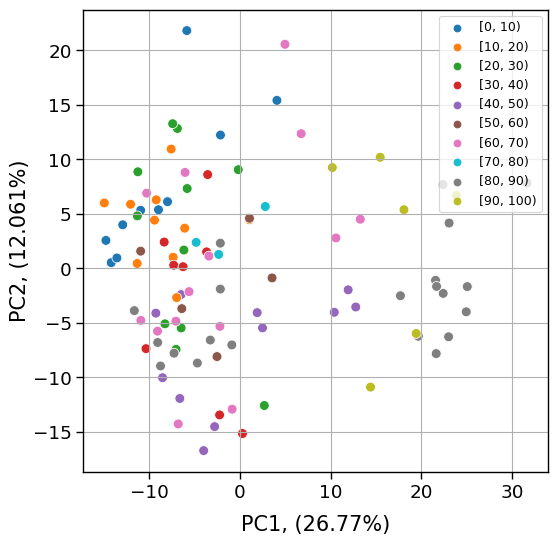

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_context("paper", font_scale=1.5)
sns.scatterplot(data=pcdf, x="PC1", y="PC2", hue="AgeRanges", s = 50)
plt.legend(loc="upper right", fontsize=5)

var_pc1 = (pca.explained_variance_ratio_[0]*100).round(3)
var_pc2 = (pca.explained_variance_ratio_[1]*100).round(3)
plt.xlabel('PC1, ('+ var_pc1.astype(str) + "%)", fontsize = 15, labelpad = 10)
plt.ylabel('PC2, ('+ var_pc2.astype(str) + "%)", fontsize = 15, labelpad = 2)

handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5,6,9,7,8]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=9)

ax.grid()

## Statistical testing

Run Likelihood Ratio Test (LRT) available in DESeq2 package:

In [27]:
%%capture
res = d.LRT_testing()

Sort genes by the adjusted p-value:

In [28]:
res = res.sort_values(by=['padj']) 

Retrieve all the genes satisfying p-value cut-off criteria $P<0.05$:

In [29]:
sig = res[res['padj'] < 0.05]

Check the number of significant genes:

In [30]:
print("Number of DE genes:", sig.shape[0])

Number of DE genes: 8449


```{admonition} Exercise 2
:class: dropdown
Define the number of up- and down-regulated genes in the analysis (0.5 points). Investigate the top 10 DE genes from up and down lists. Do they have any established connection with aging? If yes, support your claim with some references and short description of their functions. (1.5 points). 
```

In [31]:
up_regulated =  sig[sig['log2FoldChange'] > np.log2(1.5)].sort_values(by='padj').head(10)

In [32]:
up_regulated.index

Index(['RRAS2', 'AKAP2', 'STS', 'RNF149', 'SWAP70', 'PLSCR4', 'MSTN', 'PDP1',
       'SLC35F5', 'REEP3'],
      dtype='object')

RRAS2 (RAS-related protein 2). It is part of the RAS signaling pathway, which is involved in a variety of cellular processes, including cell growth, division, and differentiation. RRAS2 has been shown to regulate oxidative stress, which is thought to be one of the major drivers of aging. https://academic.oup.com/femsyr/article/5/2/157/515456

AKAP2 AKAP2 has been shown to play a role in regulating the activity of an enzyme called AMP-activated protein kinase (AMPK), which is known to regulate cellular metabolism and oxidative stress, both of which are key factors in aging. By regulating AMPK activity, AKAP2 helps to maintain cellular homeostasis and protect against age-related damage.

STS(SIRT1) has been shown to regulate insulin signaling and glucose metabolism, which are key factors in the development of age-related diseases such as type 2 diabetes

RNF149 is a gene that is involved in the regulation of the DNA damage response. This gene has been linked to the aging process because it helps control the way cells respond to DNA damage, which is a contributing factor to aging.

SWAP70 - no info

PLSCR4 - no info

Reducing MSTN levels in mice and other animals can result in increased muscle growth and improved physical performance, indicating a possible link between MSTN and aging. - https://open-genes.com/gene/MSTN

PDP1 - no info. regulating cellular senescence by modulating the activity of the p38 MAPK signaling pathway ???

SLC35F5 - no info

In [33]:
down_regulated = sig[sig['log2FoldChange'] < -np.log2(1.5)].sort_values(by='padj').head(10)

In [34]:
down_regulated.index 

Index(['LYPD1', 'GPC2', 'NT5DC2', 'PLAT', 'TALDO1', 'SEMA4C', 'NTN4',
       'PLEKHG4B', 'NEFH', 'MYH11'],
      dtype='object')

LYPD1 - no info 
GPC2 - GPC2 (Glypican 2) is a Protein Coding gene. Diseases associated with GPC2 include Keipert Syndrome and Omodysplasia. Among its related pathways are Chondroitin sulfate/dermatan sulfate metabolism and Glycosaminoglycan metabolism 
NT5DC2 - no info P
LAT - The PLAT (Plasminogen Activator, Tissue) gene codes for the production of tissue plasminogen activator (tPA). Decline in tPA activity with age has been associated with an increased risk of age-related cardiovascular diseases, such as stroke and myocardial infarction https://www.genecards.org/cgi-bin/carddisp.pl?gene=PLAT&keywords=PLAT 
I'm tired of searching(((

## Gene clustering

To perform gene clustering we will select only a subset of significant genes, let's say 1800 the most significant features

In [35]:
ngenes = 1800

In [36]:
cluster_mat = vst_mat.loc[sig.head(ngenes).index]

Perform gene clustering by executing *degPatterns* functions from DEGreport R package:

In [37]:
%%capture
content, clust_data = d.clustering(cluster_mat)

The function above returned 15 clusters consisting of more than 16 genes that are simialar in thir expression patterns.

In [38]:
Counter(content.cluster.values)

Counter({1: 248,
         2: 415,
         3: 110,
         4: 471,
         5: 36,
         6: 186,
         7: 56,
         8: 20,
         9: 35,
         10: 18,
         11: 16,
         12: 37,
         14: 42,
         17: 16,
         20: 40})

We can use a content from *clust_data* dataframe to explore obtained expression patterns and plot them with seaborn library

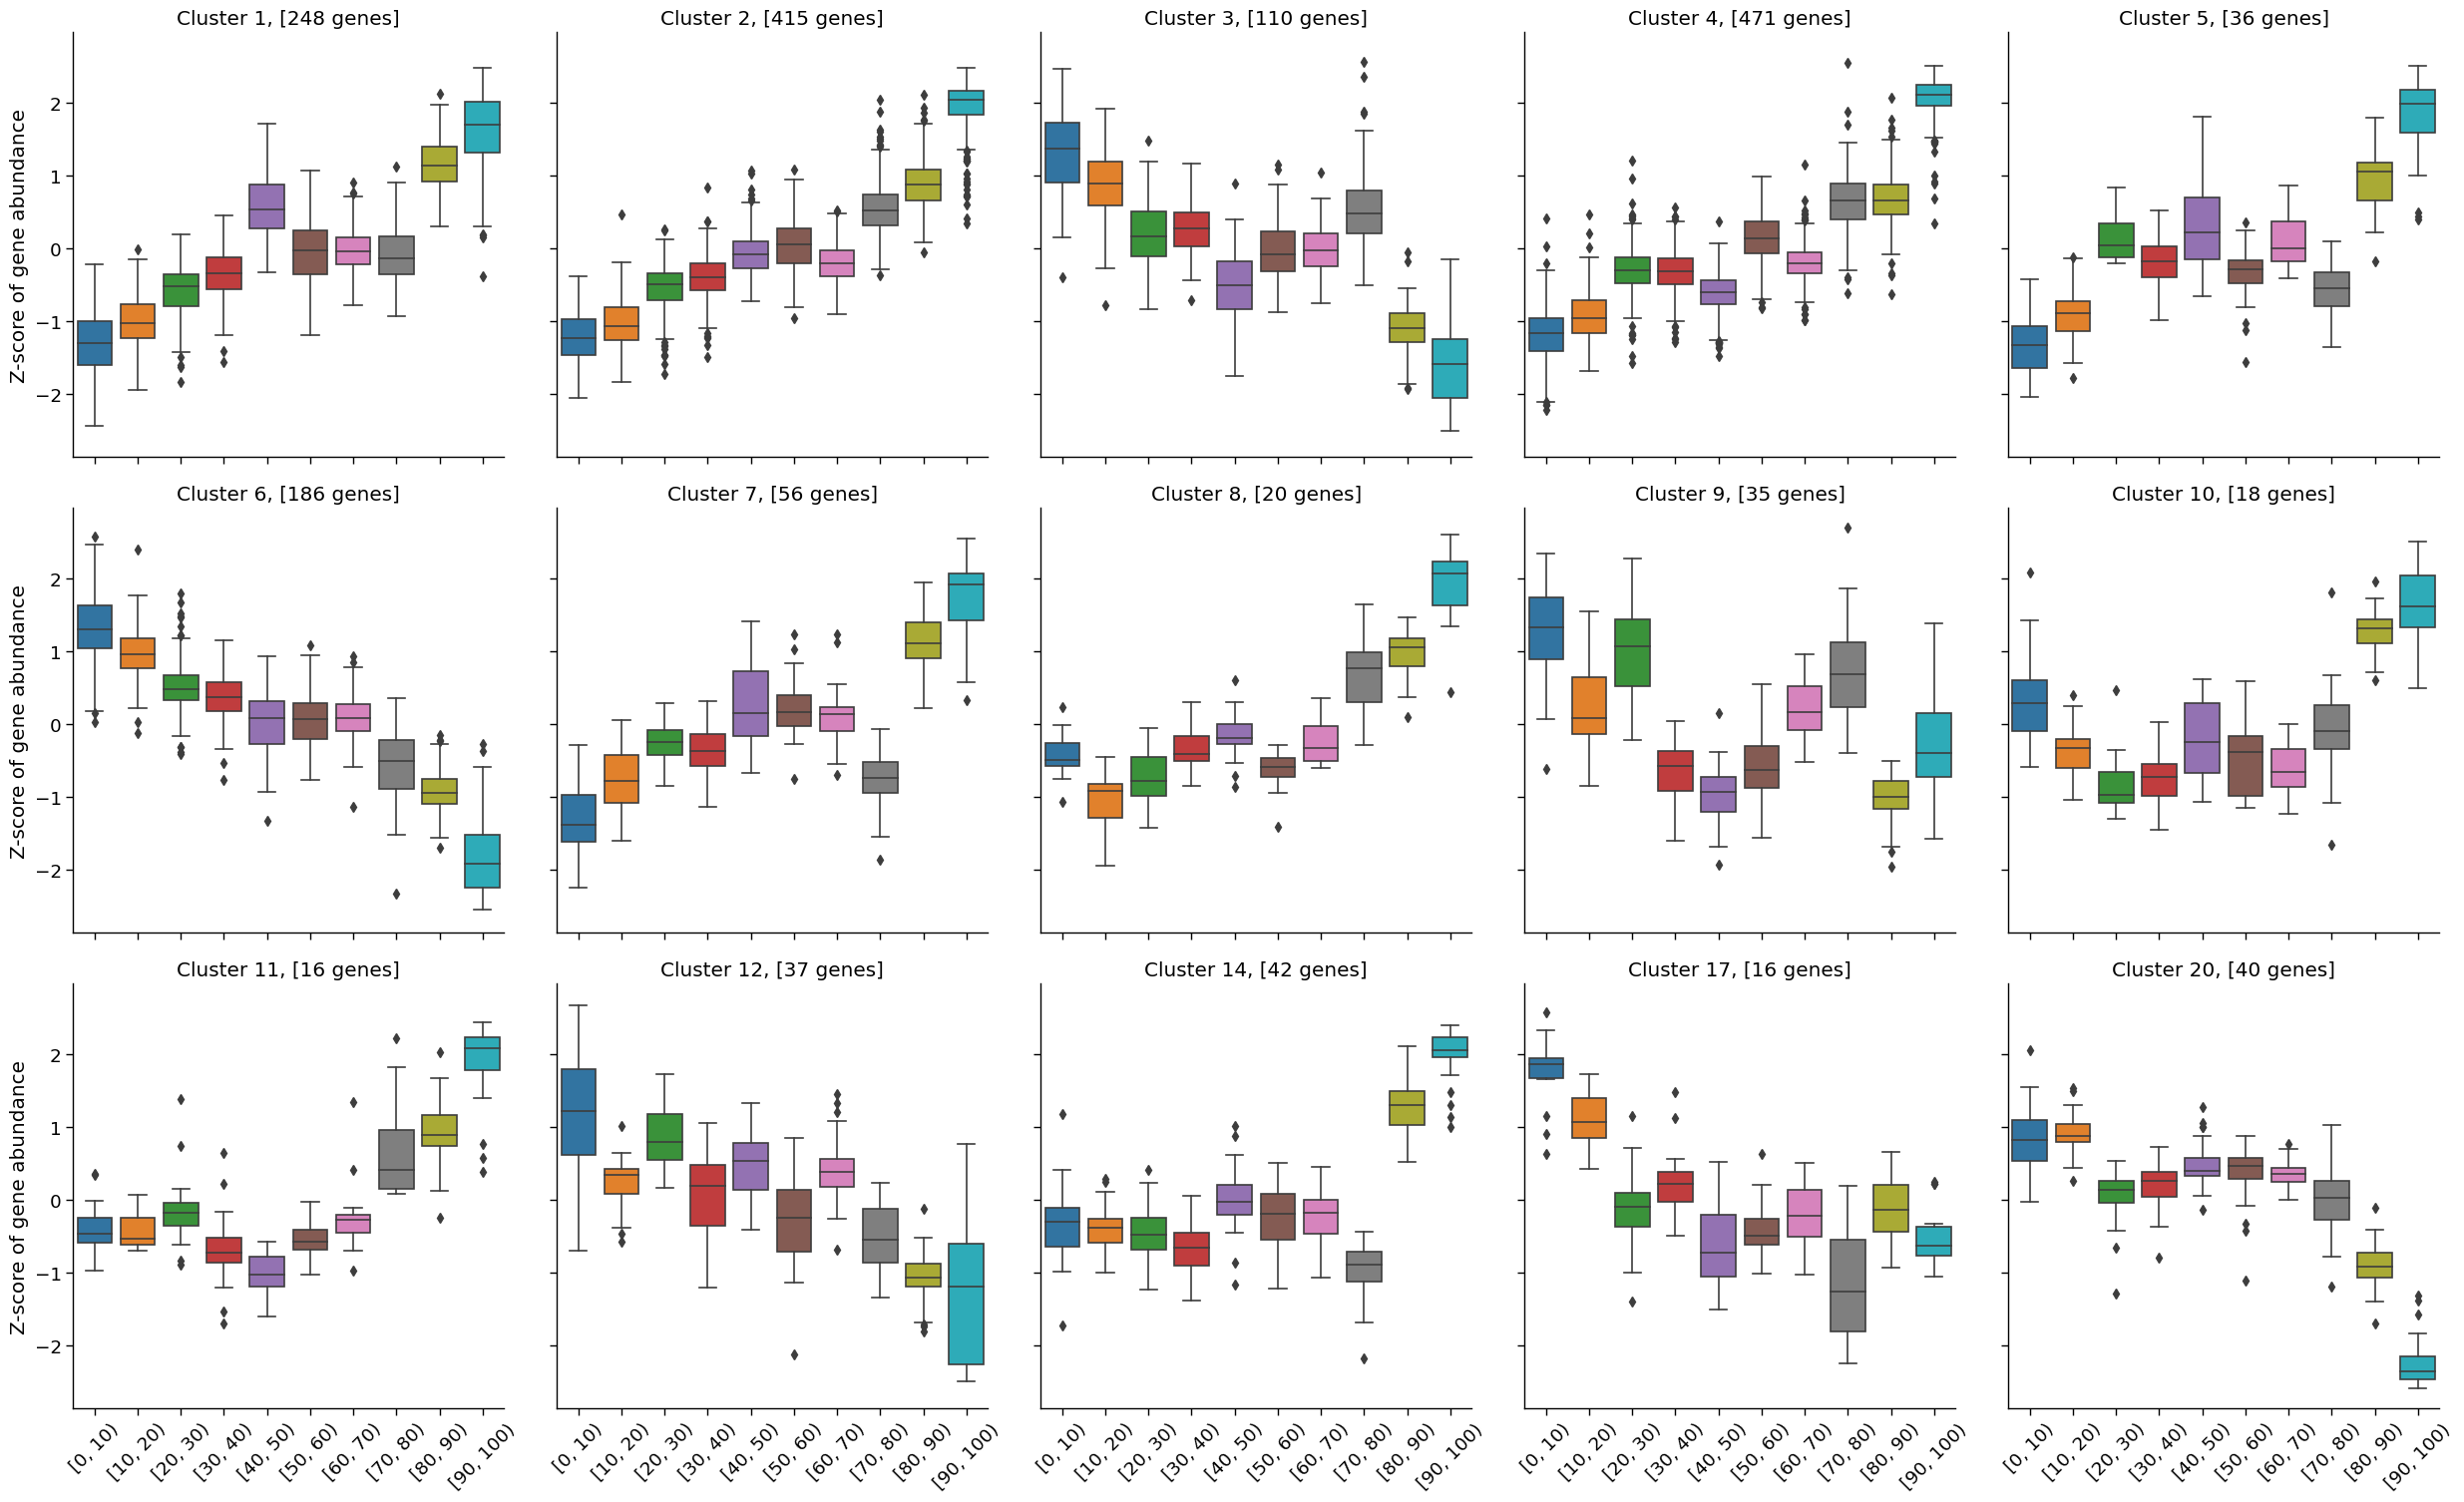

In [39]:
g = sns.catplot(data=clust_data, 
                x='AgeRanges', 
                y='value', 
                col='cluster', 
                kind='box', 
                col_wrap=5, 
                order= np.unique(clust_data.AgeRanges.values))
g.set_axis_labels("", "Z-score of gene abundance")
g.tick_params(axis='x', rotation=45)
axes = g.axes.flatten()
gene_number = Counter(content.cluster.values)
cluster_ids = list(gene_number.keys())
for i in range(len(axes)):
    axes[i].set_title("Cluster " + str(cluster_ids[i]) + ", [" + str(gene_number[cluster_ids[i]]) + " genes]")

## GO analysis

In [40]:
import gseapy
from gseapy import barplot, dotplot

Select a cluster for the GO analysis:

In [41]:
cluster_id = 2

In [42]:
enr = gseapy.enrichr(gene_list = list(content[content['cluster'] == cluster_id].genes.values),
                     background = res.index.values,
                     gene_sets=['GO_Biological_Process_2021', 
                                'GO_Cellular_Component_2021', 
                                'GO_Molecular_Function_2021'],
                     organism='human',
                     outdir=None)

For the simplicity we will drop non informative columns and keep the terms posessing 'Adjusted P-value' < 0.05

In [43]:
enr_res = enr.results.iloc[:,[0,1,2,4,9]]
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]

To visualize top 5 enrichment terms from each set (Biological Process, Cellular_Component, Molecular Function) we can apply *dotplot* function from gseapy:

<AxesSubplot:title={'center':'GO analysis'}, xlabel='Gene_set'>

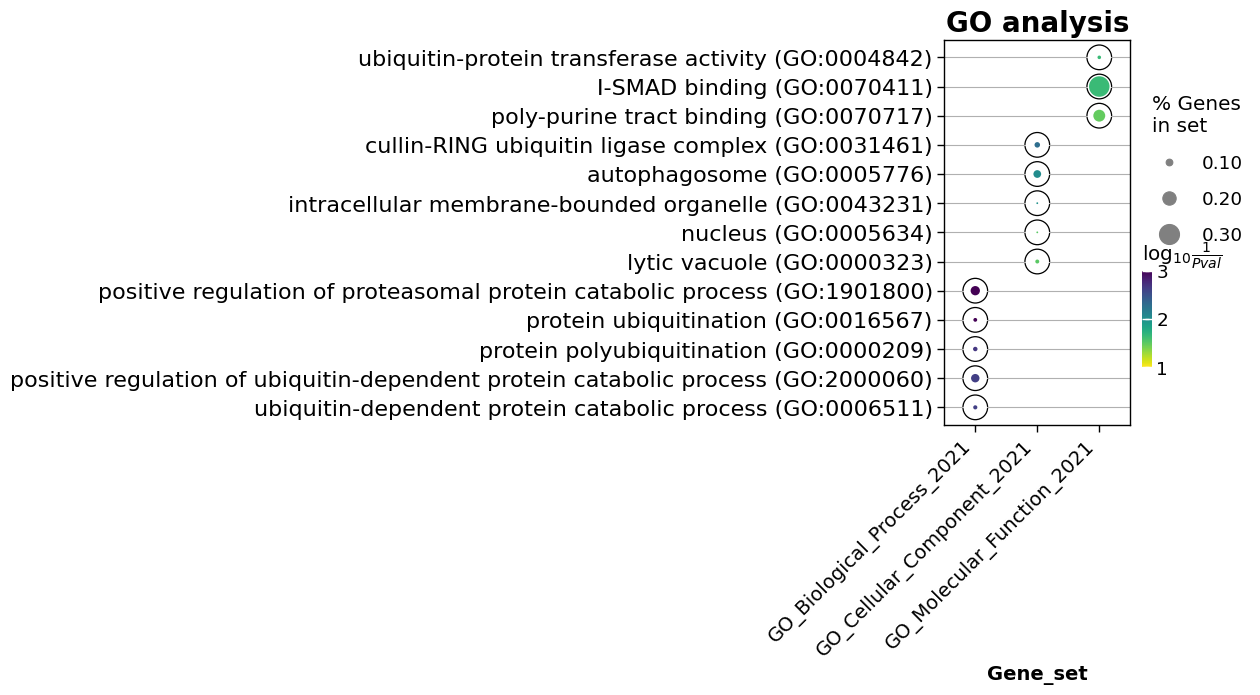

In [44]:
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=45, 
              show_ring=True, 
              marker='o',
             )

 ```{admonition} Exercise 2
:class: dropdown
Perform GO analysis on genes from clusters 1, 3, 4 and prepare figures showing the top 5 enriched terms (if possible) (1 point). 
```

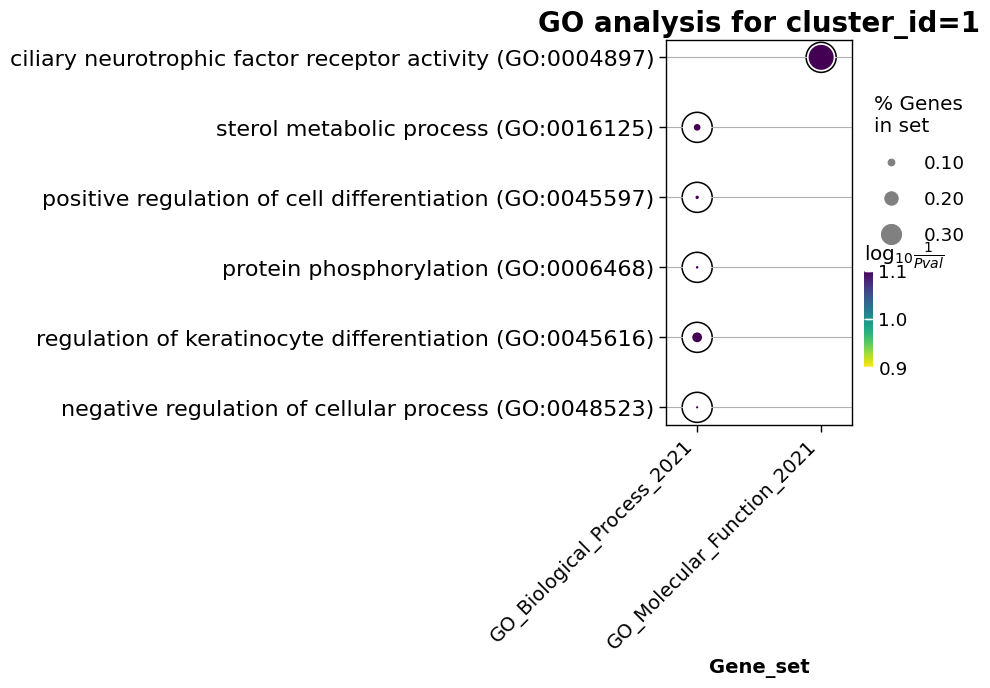

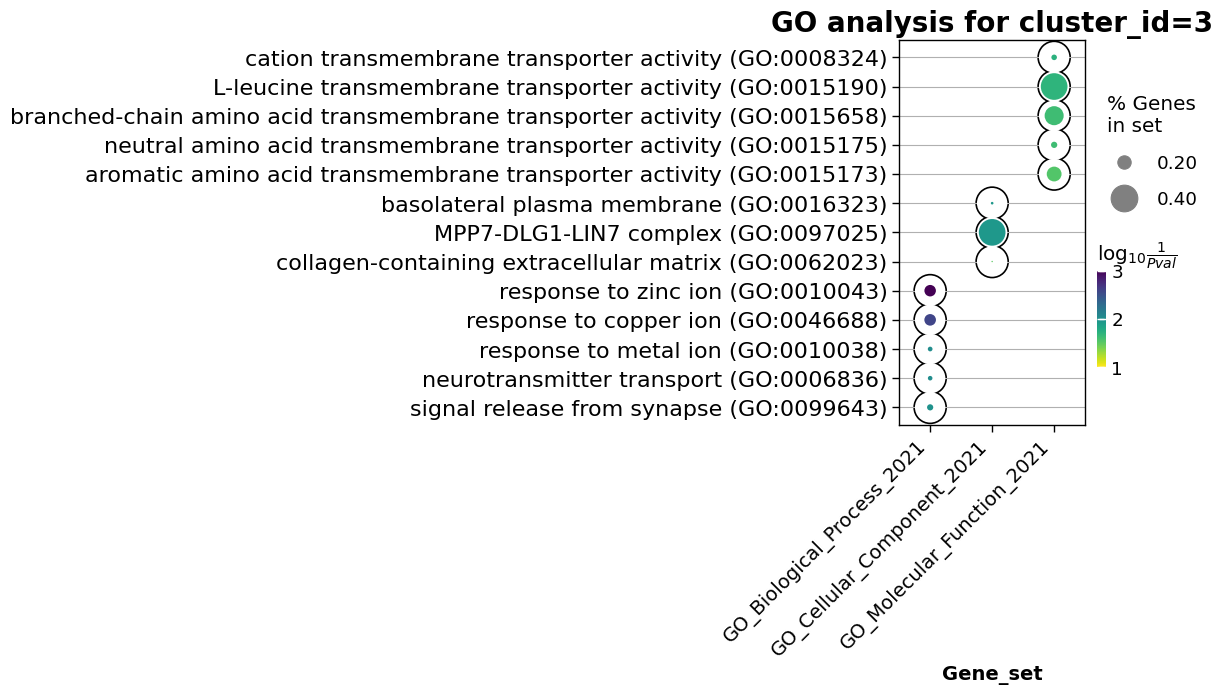

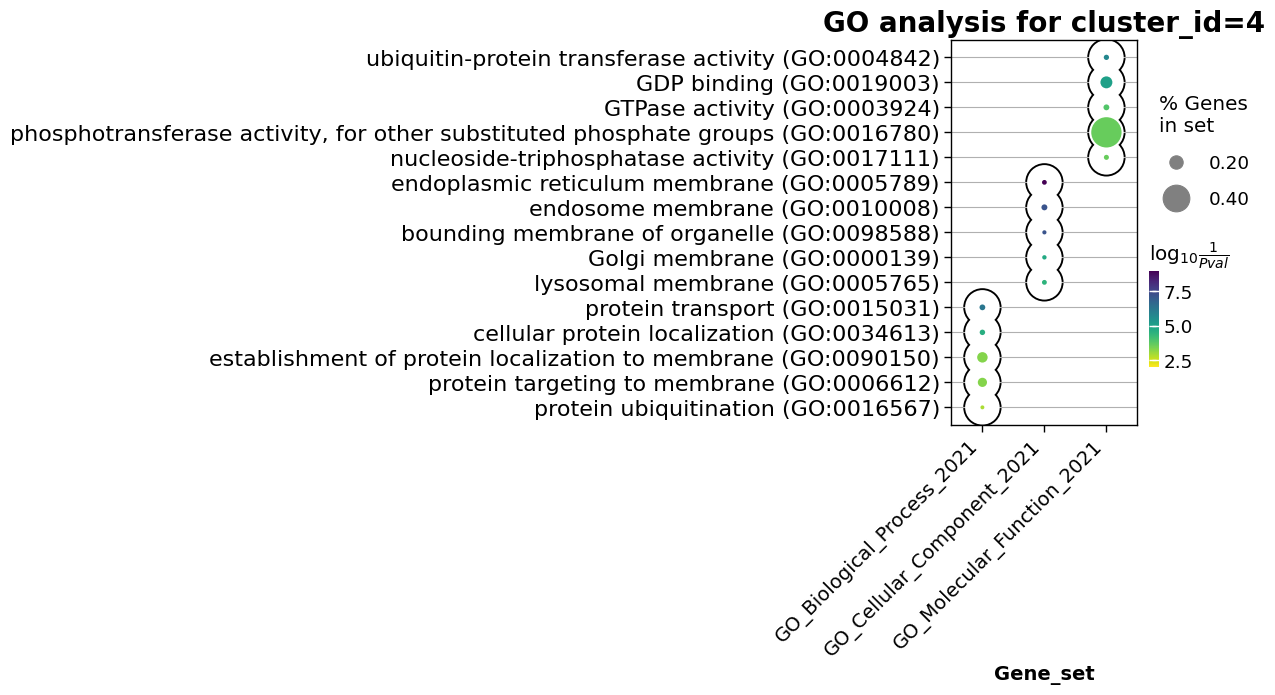

In [45]:
cluster_list = [1, 3, 4]

for cluster_id in cluster_list:
    enr = gseapy.enrichr(gene_list = list(content[content['cluster'] == cluster_id].genes.values),
                     background = res.index.values,
                     gene_sets=['GO_Biological_Process_2021', 
                                'GO_Cellular_Component_2021', 
                                'GO_Molecular_Function_2021'],
                     organism='human',
                     outdir=None)
    
    enr_res = enr.results.iloc[:,[0,1,2,4,9]]
    enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
    
    dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=10,
              top_term=5,
              figsize=(3,5),
              title =  f'GO analysis for cluster_id={cluster_id}',
              xticklabels_rot=45, 
              show_ring=True, 
              marker='o',
             )

```{admonition} Exercise 3
:class: dropdown
Perform enrichment analysis on genes from cluster 1, 3, 4 using aging related databases: 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up' and 'GTEx_Aging_Signatures_2021' (1 point).
```

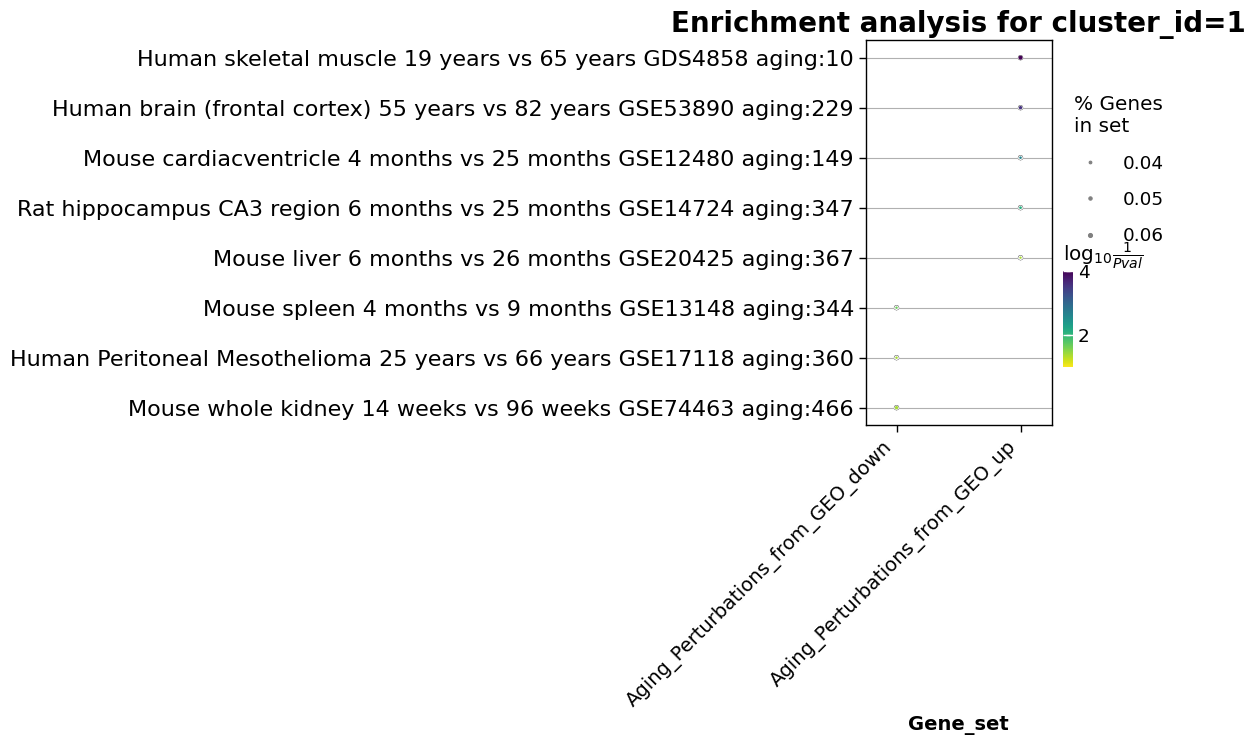

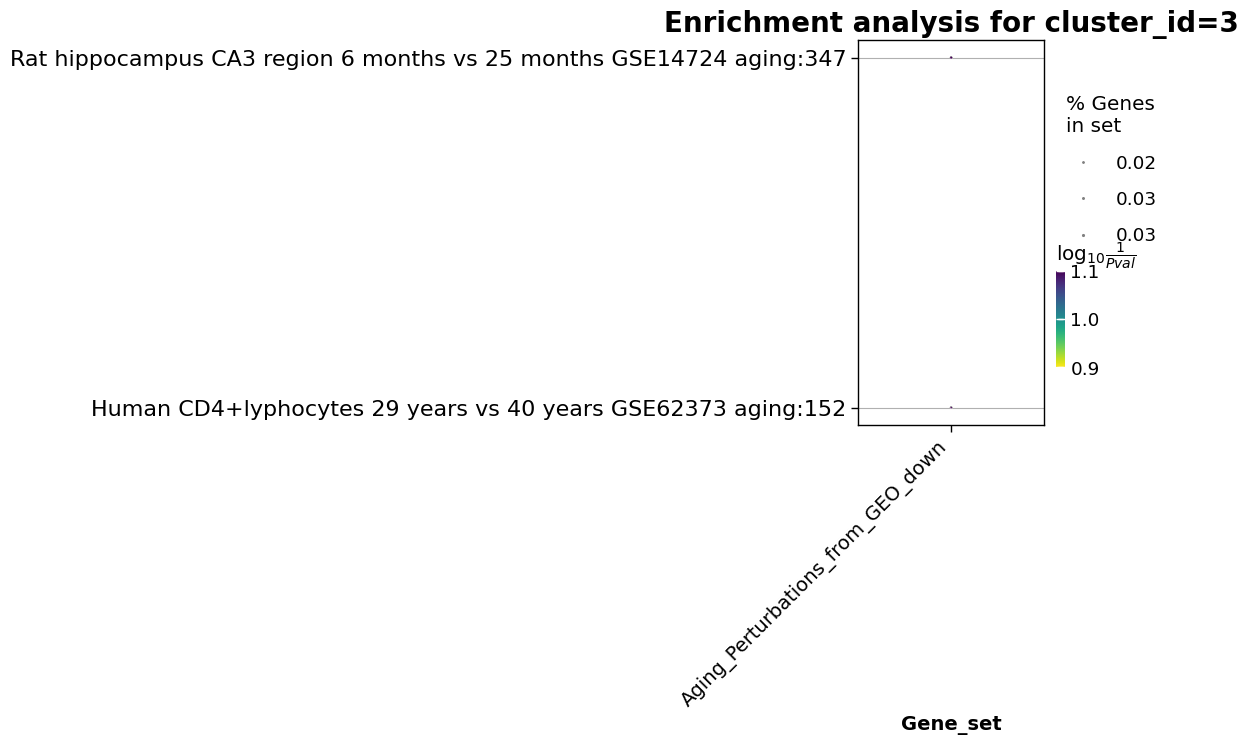

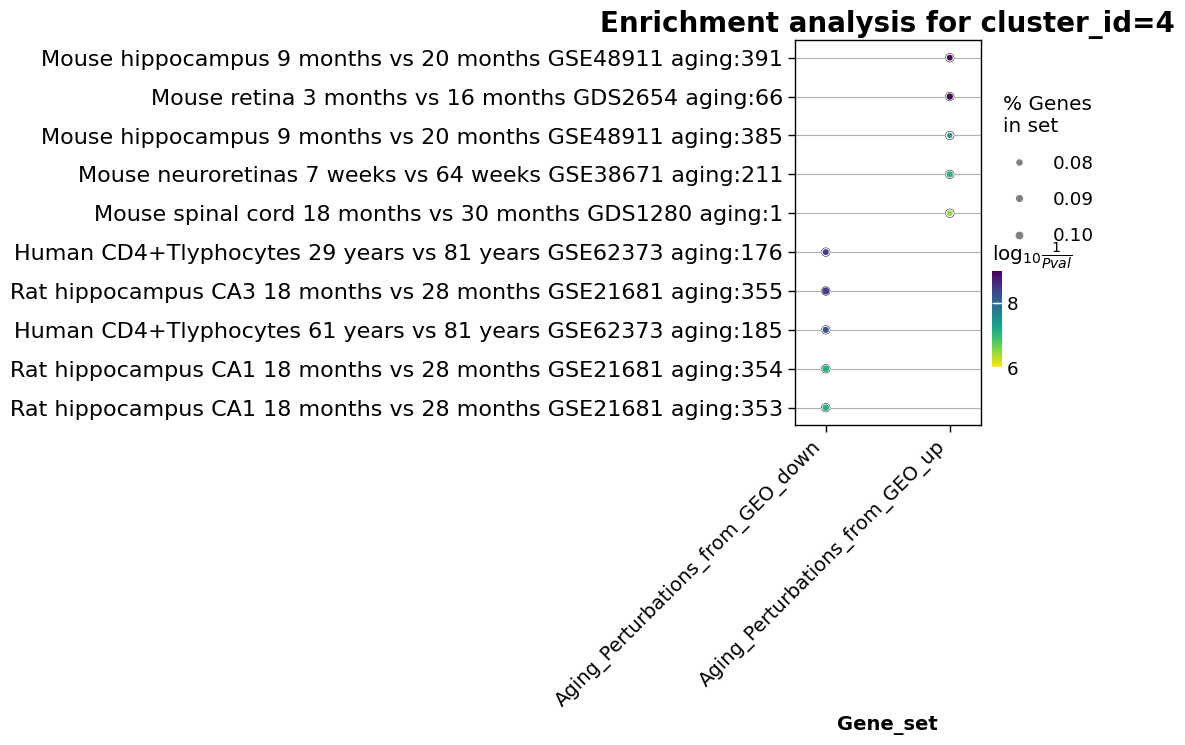

In [46]:
cluster_list = [1, 3, 4]

for cluster_id in cluster_list:    
    enr = gseapy.enrichr(gene_list = list(content[content['cluster'] == cluster_id].genes.values),
                     background = res.index.values,
                     gene_sets=['Aging_Perturbations_from_GEO_down', 
                                'Aging_Perturbations_from_GEO_up', 
                                'GTEx_Aging_Signatures_2021'],
                     organism='human',
                     outdir=None)
    
    #bool1 = enr_res.Term.str.contains('Human')       
    #bool2 = enr_res.Term.str.contains('GTEx')  
    #enr_res[bool1 | bool2].Term.values 
    
    #get_padj = robjects.r("function(x) p.adjust(x, method = 'fdr')")
    #enr_res['Adjusted P-value'] = get_padj(enr_res[['P-value']].values)
    
    enr_res = enr.results.iloc[:,[0,1,2,4,9]]
    enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
    
    dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=10,
              top_term=5,
              figsize=(3,5),
              title =  f'Enrichment analysis for cluster_id={cluster_id}',
              xticklabels_rot=45, 
              show_ring=True, 
              marker='o',
             )

## Learn more

* Detailed [manual](https://hbctraining.github.io/DGE_workshop_salmon/schedule/) on differential expression analysis with DESeq2 in R
* [RNA-seq analysis](https://pypi.org/project/RNAlysis/) with Python 
* Omics Data Analysis course at Skoltech (MA060061)

## Credits

This notebook was prepared by [Dmitrii Smirnov](https://crei.skoltech.ru/cls/people/dmitriismirnov).

## References

[1] Fleischer, J.G., Schulte, R., Tsai, H.H. et al. Predicting age from the transcriptome of human dermal fibroblasts. Genome Biol 19, 221 (2018). https://doi.org/10.1186/s13059-018-1599-6”